# Data cleaning exploration

If you are reading this, great! We hoopefully have some good results!

EDIT: hehe nop, something is really wrong. Someone find it please
EDIT EDIT: hmm maybe it is right?
We start by loading the data and the requried libraries:

In [16]:
import pandas as pd 
import numpy as np
from scipy import stats #not used atm
data = pd.read_csv("data/consumption_temp.csv")

In [17]:
data.head(5) , data.describe() , data.shape

(                  time   location  consumption  temperature
 0  2022-04-07 21:00:00     bergen     1.113325         -0.3
 1  2022-04-07 21:00:00       oslo     4.092830          1.0
 2  2022-04-07 21:00:00  stavanger     2.057858          1.3
 3  2022-04-07 21:00:00     tromsø     1.246582         -3.9
 4  2022-04-07 21:00:00  trondheim     1.970098         -2.8,
         consumption   temperature
 count  49494.000000  49494.000000
 mean       3.509242      6.554019
 std        3.096356      7.630308
 min        0.000000    -17.299999
 25%        1.263256      1.000000
 50%        2.376530      6.800000
 75%        5.189000     12.100000
 max       18.045011     30.500000,
 (49494, 4))

Looking at some of the dataframe observations, we should have a timestamp for each hour of each location (We need to check for missing values at a later point). We also have the temprature for the time and location, as well as the corresponding consumption for that hour. 

For the summary, there is not much to comment on. Lastly, we have 49,5k observations.

In [18]:
locations = data["location"].unique()
print(locations)
min_date = data["time"].min()
max_date = data["time"].max()
min_date , max_date

['bergen' 'oslo' 'stavanger' 'tromsø' 'trondheim' 'helsingfors']


('2022-04-07 21:00:00', '2023-04-02 21:00:00')

First of all, what does Hellsinki do here? We should remove this location at a later point.

We also note that we have roughly an year of observations from spring 2022 to spirng 2023.

## Manipulate the data

Next, we try to manipulate our data into a dataframe which corresponds to what information is avaliable

In [19]:


df = data.sort_values(by=['location', 'time'])
df["time"] = pd.to_datetime(df["time"])
# Calculate consumption means with shift
hours_shift_back = 4 * 24 + 11  #4 days back, plus the shift back to midnight.As in the example by ANEA, we shift from 10:00 september 19 to 23:00 septembeer 13
df["consumption-lag_5d"] = df.groupby('location')['consumption'].shift(hours_shift_back).rolling(window=24 * 1).mean()
df["consumption-lag_6d"] = df.groupby('location')['consumption'].shift(hours_shift_back + 24).rolling(window=24 * 1).mean()
df["consumption-lag_7d"] = df.groupby('location')['consumption'].shift(hours_shift_back + 24*2).rolling(window=24 * 1).mean()
df["consumption-5_mean_lag_3d"] = df.groupby('location')['consumption'].shift(hours_shift_back).rolling(window=24 * 3).mean()
df["consumption-5_mean_lag_7d"] = df.groupby('location')['consumption'].shift(hours_shift_back).rolling(window=24 * 7).mean()
df["consumption-5_mean_lag_14d"] = df.groupby('location')['consumption'].shift(hours_shift_back).rolling(window=24 * 14).mean()

# Calculate temperature means with shift
hours_shift_forward = 13  ##takes the time from 10:00 to 23:00 the same day
df["temperature_mean_lag_1d"] = df.groupby('location')['temperature'].shift(hours_shift_forward).rolling(window=24 * 1).mean()
df["temperature_mean_lag_3d"] = df.groupby('location')['temperature'].shift(hours_shift_forward).rolling(window=24 * 3).mean()
df["temperature_mean_lag_7d"] = df.groupby('location')['temperature'].shift(hours_shift_forward).rolling(window=24 * 7).mean()
df["temperature_mean_lag_14d"] = df.groupby('location')['temperature'].shift(hours_shift_forward).rolling(window=24 * 14).mean()

df_days_before = df[df["time"].dt.time == pd.to_datetime("10:00:00").time()]                 # we only need the historic values at 10:00
df_days_before.dropna(inplace=True)                                                     #For some dates we do not have the amount of data to calculate the means, we therefore drop them
df_days_before["date_of_prediction"] = (pd.to_datetime(df_days_before["time"]) - pd.Timedelta(days=1)).dt.date                 # the date of which the prediction was made
df_days_before.drop(columns=["consumption","temperature","time"],inplace=True)                 # Not relevant for the days before



C:\Users\marti\AppData\Local\Temp\ipykernel_19184\1289179370.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_days_before.dropna(inplace=True)                                                     #For some dates we do not have the amount of data to calculate the means, we therefore drop them
C:\Users\marti\AppData\Local\Temp\ipykernel_19184\1289179370.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_days_before["date_of_prediction"] = (pd.to_datetime(df_days_before["time"]) - pd.Timedelta(days=1)).dt.date                 # the date of which the predi

location                       object
consumption-lag_5d            float64
consumption-lag_6d            float64
consumption-lag_7d            float64
consumption-5_mean_lag_3d     float64
consumption-5_mean_lag_7d     float64
consumption-5_mean_lag_14d    float64
temperature_mean_lag_1d       float64
temperature_mean_lag_3d       float64
temperature_mean_lag_7d       float64
temperature_mean_lag_14d      float64
date_of_prediction             object
dtype: object

This dataframe contains historic value that we can use for our predictions each day. Note that the lag values for consiumptions starts 5 days a head of the day which we are predicting for. This is due to the restriction in the given problem. The temperatur, however, has the lags from the same day of the prediction.


Next up, we have to combine our historic data with each hours prediction ahead in time. Since we also have the temprature forecasts a head of time, we can use the current forcasted value, as well as the previous hours.

In [20]:
df = data.sort_values(by=["location", "time"])
df["temperature_mean_lag_1h"] = df.groupby("location")["temperature"].shift(1).rolling(window=1).mean()
df["temperature_mean_lag_3h"] = df.groupby("location")["temperature"].shift(1).rolling(window=3).mean()
df["temperature_mean_lag_6h"] = df.groupby("location")["temperature"].shift(1).rolling(window=6).mean()
df["date_of_prediction"] = (pd.to_datetime(df["time"]) - pd.Timedelta(days=1)).dt.date



If we merge these two frames, we get the historic information for each variable timepoint we are predicting.

In [21]:
df_full = df.merge(df_days_before,on=["date_of_prediction","location"])
df_full

,time,location,consumption,temperature,temperature_mean_lag_1h,temperature_mean_lag_3h,temperature_mean_lag_6h,date_of_prediction,consumption-lag_5d,consumption-lag_6d,consumption-lag_7d,consumption-5_mean_lag_3d,consumption-5_mean_lag_7d,consumption-5_mean_lag_14d,temperature_mean_lag_1d,temperature_mean_lag_3d,temperature_mean_lag_7d,temperature_mean_lag_14d
0,2022-04-26 00:00:00,bergen,0.583449,4.0,4.1,4.233333,6.166667,2022-04-25,0.643492,0.690125,0.740671,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452
1,2022-04-26 01:00:00,bergen,0.597281,3.3,4.0,4.033333,5.133333,2022-04-25,0.643492,0.690125,0.740671,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452
2,2022-04-26 02:00:00,bergen,0.592792,2.9,3.3,3.800000,4.350000,2022-04-25,0.643492,0.690125,0.740671,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452
3,2022-04-26 03:00:00,bergen,0.604434,2.9,2.9,3.400000,3.816667,2022-04-25,0.643492,0.690125,0.740671,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452
4,2022-04-26 04:00:00,bergen,0.664663,2.6,2.9,3.033333,3.533333,2022-04-25,0.643492,0.690125,0.740671,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46879,2023-04-02 17:00:00,trondheim,3.927136,3.6,5.9,6.366667,6.400000,2023-04-01,3.619001,3.423687,3.655065,3.565918,3.400604,3.393061,-2.000000,-3.430556,-4.319643,-1.960119
46880,2023-04-02 18:00:00,trondheim,4.067940,3.0,3.6,5.400000,6.033333,2023-04-01,3.619001,3.423687,3.655065,3.565918,3.400604,3.393061,-2.000000,-3.430556,-4.319643,-1.960119
46881,2023-04-02 19:00:00,trondheim,4.093120,1.4,3.0,4.166667,5.433333,2023-04-01,3.619001,3.423687,3.655065,3.565918,3.400604,3.393061,-2.000000,-3.430556,-4.319643,-1.960119
46882,2023-04-02 20:00:00,trondheim,3.990767,-2.7,1.4,2.666667,4.516667,2023-04-01,3.619001,3.423687,3.655065,3.565918,3.400604,3.393061,-2.000000,-3.430556,-4.319643,-1.960119


## Extract info from date

Firsty, we check if the datatypes match, which they do.

In [22]:
df_full.dtypes

time                           object
location                       object
consumption                   float64
temperature                   float64
temperature_mean_lag_1h       float64
temperature_mean_lag_3h       float64
temperature_mean_lag_6h       float64
date_of_prediction             object
consumption-lag_5d            float64
consumption-lag_6d            float64
consumption-lag_7d            float64
consumption-5_mean_lag_3d     float64
consumption-5_mean_lag_7d     float64
consumption-5_mean_lag_14d    float64
temperature_mean_lag_1d       float64
temperature_mean_lag_3d       float64
temperature_mean_lag_7d       float64
temperature_mean_lag_14d      float64
dtype: object

We add some important feautures from the date

In [23]:
df_full["time"] = pd.to_datetime(df_full["time"])
df_full["day_of_week"] = df_full["time"].dt.dayofweek
df_full["day_of_year"] = df_full["time"].dt.dayofyear
df_full["hour_of_day"] = df_full["time"].dt.hour


Lets do a pairs plot

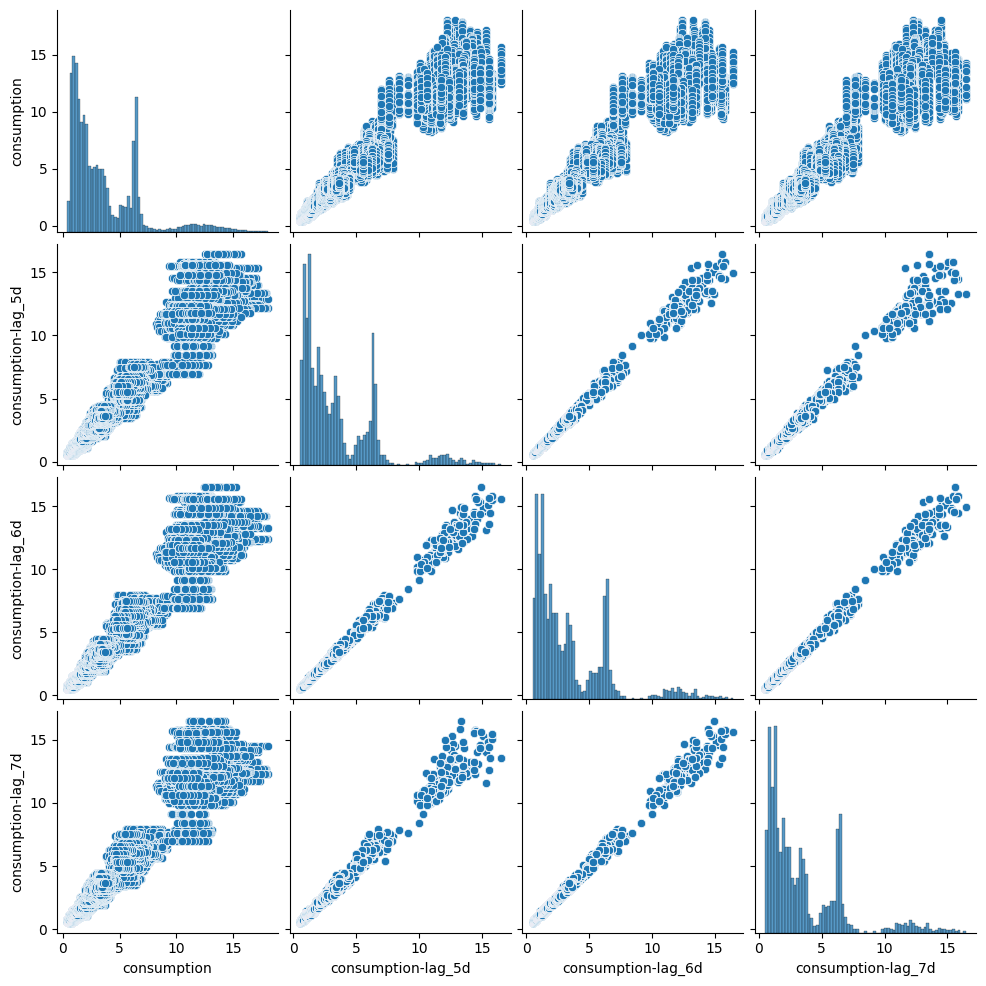

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_full[["consumption","consumption-lag_5d","consumption-lag_6d","consumption-lag_7d"]])
plt.show()

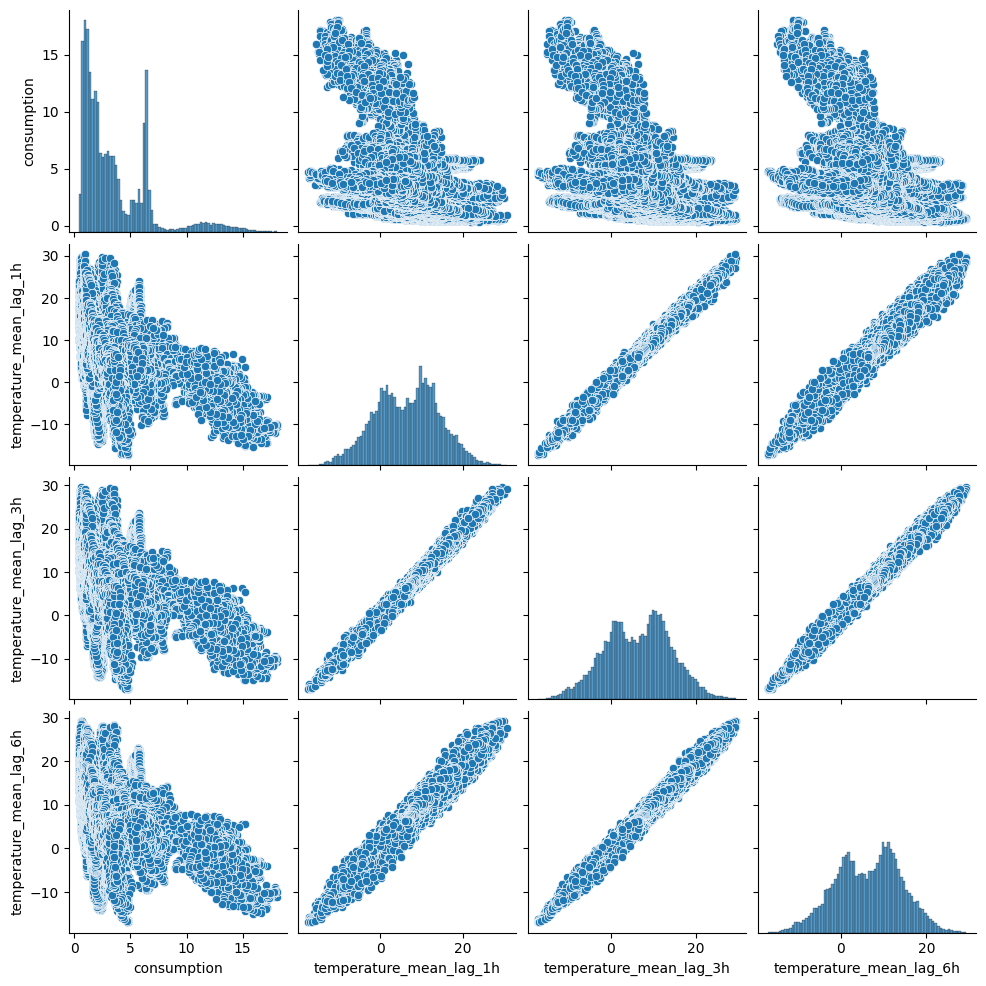

In [26]:
sns.pairplot(df_full[["consumption","temperature_mean_lag_1h","temperature_mean_lag_3h","temperature_mean_lag_6h"]])
plt.show()

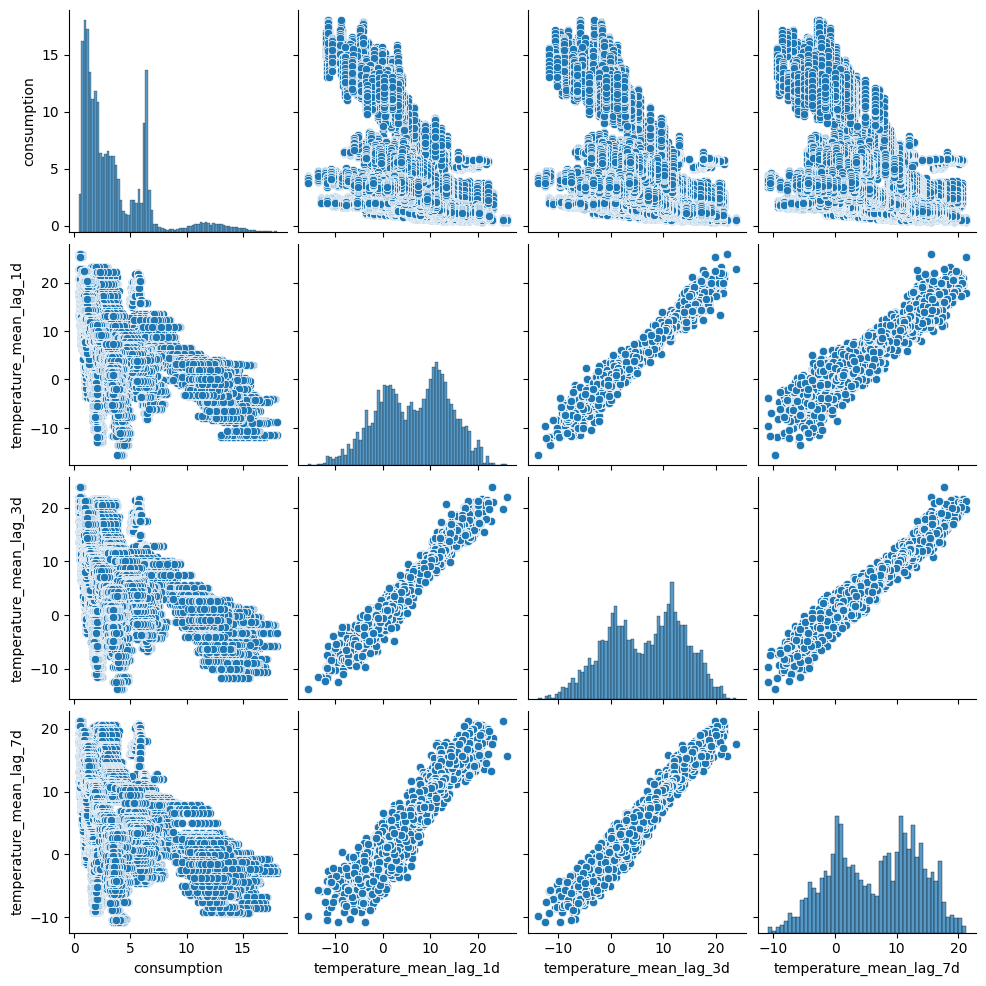

In [30]:

sns.pairplot(df_full[["consumption","temperature_mean_lag_1d","temperature_mean_lag_3d","temperature_mean_lag_7d"]])
plt.show()

In [35]:
df = df_full.drop(columns=["time","date_of_prediction"])
df = pd.get_dummies(df,columns=["location"])
df_full = df.copy()

In [33]:
df.corr()

,consumption,temperature,temperature_mean_lag_1h,temperature_mean_lag_3h,temperature_mean_lag_6h,consumption-lag_5d,consumption-lag_6d,consumption-lag_7d,consumption-5_mean_lag_3d,consumption-5_mean_lag_7d,...,temperature_mean_lag_14d,day_of_week,day_of_year,hour_of_day,location_bergen,location_helsingfors,location_oslo,location_stavanger,location_tromsø,location_trondheim
consumption,1.000000,-0.449241,-0.447414,-0.446743,-0.448090,0.975877,0.973258,0.971153,0.974943,0.973759,...,-0.460269,0.017066,-0.103330,0.059326,-0.244820,0.321812,0.510703,-0.029667,-0.328658,-0.187508
temperature,-0.449241,1.000000,0.995416,0.987099,0.970737,-0.430363,-0.427774,-0.426115,-0.428751,-0.429564,...,0.863841,-0.018702,0.189615,0.050131,0.075356,-0.077453,0.053972,0.127739,-0.174313,-0.015375
temperature_mean_lag_1h,-0.447414,0.995416,1.000000,0.996305,0.983608,-0.430448,-0.427798,-0.426099,-0.428782,-0.429522,...,0.864333,-0.018713,0.189816,0.076348,0.075328,-0.077362,0.053998,0.127728,-0.174377,-0.015377
temperature_mean_lag_3h,-0.446743,0.987099,0.996305,1.000000,0.993992,-0.431680,-0.428946,-0.427207,-0.429946,-0.430613,...,0.867116,-0.018780,0.190546,0.098032,0.075494,-0.077466,0.054168,0.128042,-0.174884,-0.015430
temperature_mean_lag_6h,-0.448090,0.970737,0.983608,0.993992,1.000000,-0.434502,-0.431621,-0.429822,-0.432654,-0.433217,...,0.873219,-0.019207,0.192079,0.114346,0.075904,-0.077779,0.054526,0.128779,-0.175992,-0.015555
consumption-lag_5d,0.975877,-0.430363,-0.430448,-0.431680,-0.434502,1.000000,0.996763,0.992538,0.997984,0.993752,...,-0.479446,0.002019,-0.127538,-0.000241,-0.245471,0.329057,0.506058,-0.031574,-0.327807,-0.187459
consumption-lag_6d,0.973258,-0.427774,-0.427798,-0.428946,-0.431621,0.996763,1.000000,0.996757,0.999389,0.996015,...,-0.481066,0.009224,-0.131667,-0.000225,-0.245268,0.330106,0.504288,-0.031875,-0.327137,-0.187173
consumption-lag_7d,0.971153,-0.426115,-0.426099,-0.427207,-0.429822,0.992538,0.996757,1.000000,0.997975,0.997288,...,-0.482356,0.017932,-0.137782,-0.000225,-0.245001,0.331078,0.502559,-0.032131,-0.326537,-0.186903
consumption-5_mean_lag_3d,0.974943,-0.428751,-0.428782,-0.429946,-0.432654,0.997984,0.999389,0.997975,1.000000,0.997230,...,-0.481701,0.009733,-0.132530,-0.000231,-0.245628,0.330592,0.505087,-0.031909,-0.327669,-0.187469
consumption-5_mean_lag_7d,0.973759,-0.429564,-0.429522,-0.430613,-0.433217,0.993752,0.996015,0.997288,0.997230,1.000000,...,-0.485036,0.003896,-0.144367,-0.000206,-0.245553,0.331775,0.503425,-0.032188,-0.327088,-0.187214


In [34]:
df_full.to_parquet("clean.parquet")